<a href="https://colab.research.google.com/github/ymuto0302/PJ2024/blob/main/GIS2_pop_density.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 地理情報の活用(2)：「地図で見る統計(統計GIS)」を用いた人口密度分布の可視化

## [目標] 人口密度の可視化
政府統計の総合窓口(e-Stat)では「地図で見る統計(統計GIS)」 https://www.e-stat.go.jp/gis が提供されており，国勢調査の結果等が公開されている。

国勢調査により得られたデータを元に「人口密度の可視化」を試みよう。

---
### 国勢調査に関する Shape file の入手 (段階的な手順)
1. 「e-Stat 政府統計の窓口：統計地理情報システム」 https://www.e-stat.go.jp/gis へアクセスする。
1. 「境界データダウンロード → 小地域 → 国勢調査 → 2020年 → 小地域（町丁・字等別）」と順次，進む。

当該ページへ一気に飛ぶには，下記の URL を利用する。
https://www.e-stat.go.jp/gis/statmap-search?page=1&type=2&aggregateUnitForBoundary=A&toukeiCode=00200521&toukeiYear=2020&serveyId=A002005212020&datum=2000

以上の手順により到達したページを以下に示す。

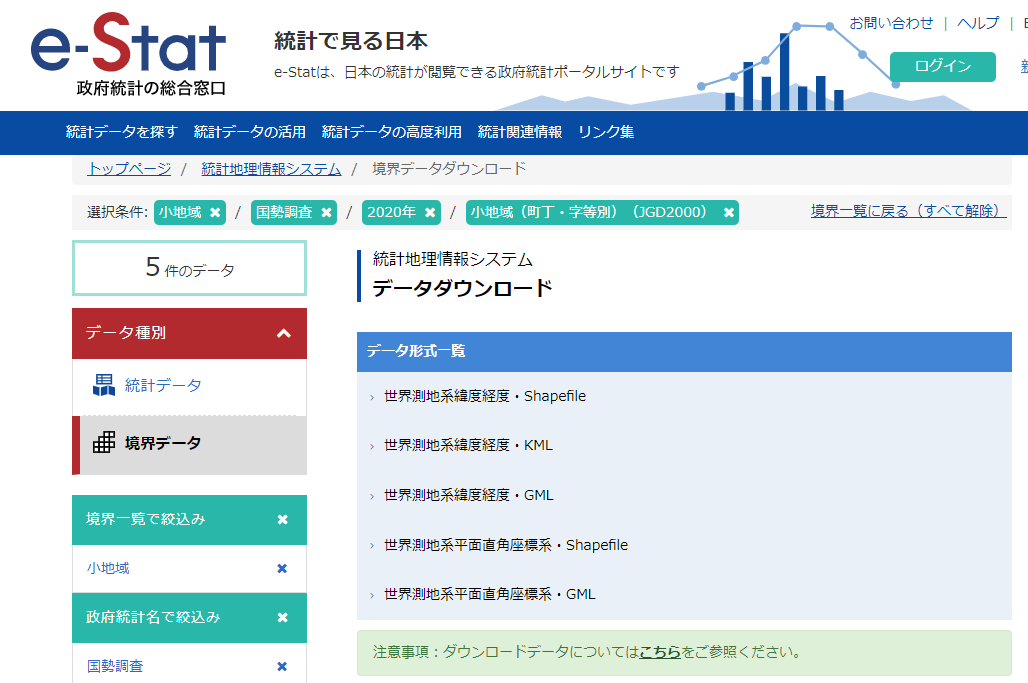

このページにおいて，「**世界測地系緯度経度・Shapefile**」を選択した後，自分の関心がある地域の shape file を入手すればよい。

(参考) shape file に含まれるデータの詳細は「令和２年国勢調査町丁・字等別境界データ データベース定義書」を参照すること。

https://www.e-stat.go.jp/gis/statmap-search/data?datatype=2&serveyId=A002005212020&downloadType=1&datum=2000

---
### (準備) geopandas のインストール

In [1]:
!pip install geopandas

### (準備) Google Drive のマウント

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


---
### データ取得から人口密度の可視化までのプロセス
予め，人口密度を可視化するまでの手順を列挙しておく。

1. 注目する地域の shape データを e-stat からダウンロード
1. 海面（水面調査区）の削除
1. 人口密度を求める
1. 可視化

---
### 人口密度の可視化：福岡県全域を例として
下記のページから福岡県全域の shape file を入手する。
https://www.e-stat.go.jp/gis/statmap-search?page=1&type=2&aggregateUnitForBoundary=A&toukeiCode=00200521&toukeiYear=2020&serveyId=A002005212020&prefCode=40&coordsys=1&format=shape&datum=2000

ダウンロードしたファイルは zip 形式であるため，適当なディレクトリに展開する。

以下の例では，zip ファイル展開後のファイル群をディレクトリ
```
/content/drive/MyDrive/BASE/GeoData/e-stat/Fukuoka/
```
下に置いている。

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 地理情報データの読み込み
path = r'/content/drive/My Drive/BASE/GeoData/e-stat/Fukuoka/r2ka40.shp' # 福岡県
fukuoka = gpd.read_file(path)

読み込まれたデータには，「令和２年国勢調査町丁・字等別境界データ　データベース定義書」にて定義された項目（列）である
PREF, PREF_NAME, CITY_NAME, AREA, JINKO 等が含まれる。

- PREF : 都道府県番号 (福岡県は 40)
- PREF_NAME : 都道府県名
- CITY_NAME : 市名または区名
- AREA : 面積
- JINKO : 人口

In [4]:
# (参考) 確認のため，読み込んだデータの先頭を表示
fukuoka.head()

,KEY_CODE,PREF,CITY,S_AREA,PREF_NAME,CITY_NAME,S_NAME,KIGO_E,HCODE,AREA,...,N_KEN,N_CITY,KIGO_I,KBSUM,JINKO,SETAI,X_CODE,Y_CODE,KCODE1,geometry
0,40,40,202,000000,福岡県,大牟田市,None,None,8101,2607.880,...,43,204,None,0,0,0,130.437353,33.005958,0000-00,"POLYGON ((130.43802 33.00572, 130.43796 33.005..."
1,40,40,202,000000,福岡県,大牟田市,None,None,8101,1258.306,...,43,204,None,0,0,0,130.453768,33.005356,0000-00,"POLYGON ((130.45395 33.00564, 130.45372 33.004..."
2,40,40,202,000000,福岡県,大牟田市,None,None,8101,11781.687,...,43,204,None,0,0,0,130.447436,33.005881,0000-00,"POLYGON ((130.44791 33.00536, 130.44786 33.005..."
3,401010010,40,101,001000,福岡県,北九州市門司区,青葉台,None,8101,101576.576,...,None,None,None,20,260,112,130.920827,33.884993,0010-00,"POLYGON ((130.92331 33.88419, 130.92313 33.883..."
4,401010020,40,101,002000,福岡県,北九州市門司区,大字伊川,None,8101,4698989.820,...,None,None,None,20,749,349,130.973557,33.910546,0020-00,"POLYGON ((130.96698 33.92406, 130.96784 33.923..."


In [5]:
# (参考) データフレーム fukuoka に含まれる列名の一覧
fukuoka.columns

Index(['KEY_CODE', 'PREF', 'CITY', 'S_AREA', 'PREF_NAME', 'CITY_NAME',
       'S_NAME', 'KIGO_E', 'HCODE', 'AREA', 'PERIMETER', 'R2KAxx', 'R2KAxx_ID',
       'KIHON1', 'DUMMY1', 'KIHON2', 'KEYCODE1', 'KEYCODE2', 'AREA_MAX_F',
       'KIGO_D', 'N_KEN', 'N_CITY', 'KIGO_I', 'KBSUM', 'JINKO', 'SETAI',
       'X_CODE', 'Y_CODE', 'KCODE1', 'geometry'],
      dtype='object')

<Axes: >

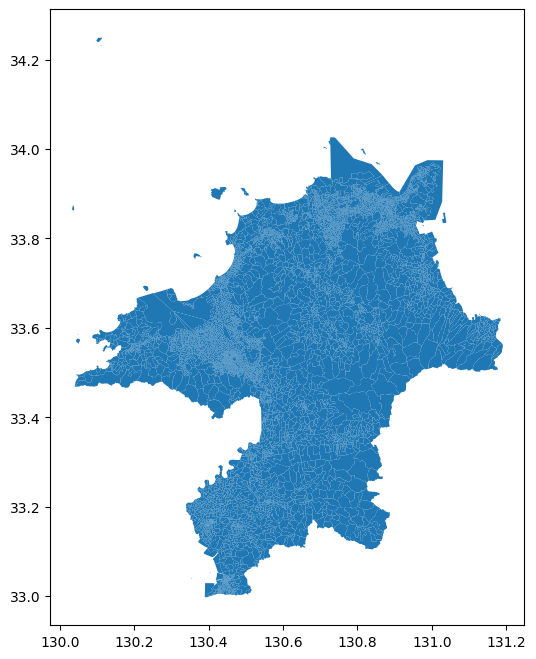

In [6]:
# geopandas の plot 機能を用いた描画
fukuoka.plot(figsize=(16, 8))

#### 「海面」の除去
上記の地図を見ると海岸線が不自然である。（例えば北九州市や福岡市の沖を見て欲しい）

これはデータ中に「海面」を含むためである。

「海面」を削除するには「分類コード (HCODE)」を見ればよい。

**分類コード (HCODE) の値：**
- 「8101」：町丁・字等
- 「8154」：水面調査区

値 8154 が意味する「水面調査区」とは一般に「海面」を指しており，人口密度を求める観点から不要だから，次のコードにより削除する。

In [8]:
# 水面調査区の除去 (水面でない部分を残す)
fukuoka = fukuoka[fukuoka['HCODE'] != 8154]

改めて，データを可視化してみよう。

水面調査区の除去により，自然な地理情報データが得られていることが分かるだろう。

<Axes: >

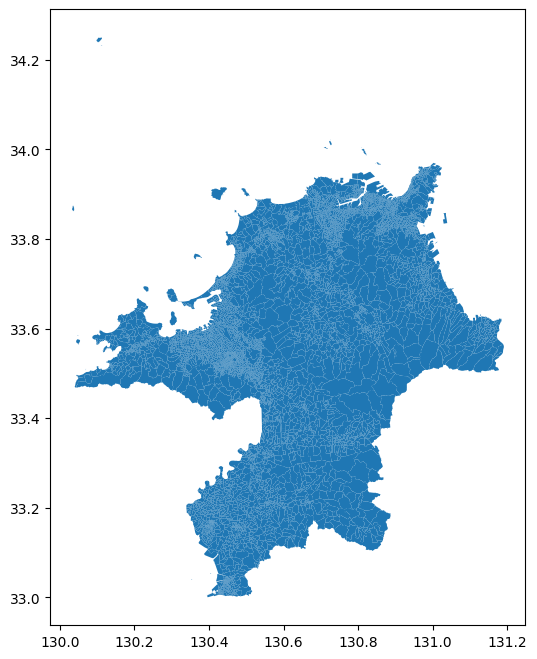

In [9]:
# geopandas の plot 機能を用いた描画
fukuoka.plot(figsize=(16, 8))

#### 人口密度の算出
定義書に従うと，項目「JINKO」は人口総数（単位：人），項目「AREA」は面積（単位：平方メートル）である。

故に，人口総数(JINKO) ÷ 面積(AREA)により人口密度[人/m2]を求めることができる。

ここでは，人口密度 (POP_DENSITY) を新たな項目として GeoDataframe へ付与する。

In [10]:
# 人口密度を求める
fukuoka['POP_DENSITY'] = fukuoka['JINKO'] / fukuoka['AREA']

In [11]:
# 一応，中身を確認
fukuoka.head()

,KEY_CODE,PREF,CITY,S_AREA,PREF_NAME,CITY_NAME,S_NAME,KIGO_E,HCODE,AREA,...,N_CITY,KIGO_I,KBSUM,JINKO,SETAI,X_CODE,Y_CODE,KCODE1,geometry,POP_DENSITY
0,40,40,202,000000,福岡県,大牟田市,None,None,8101,2607.880,...,204,None,0,0,0,130.437353,33.005958,0000-00,"POLYGON ((130.43802 33.00572, 130.43796 33.005...",0.000000
1,40,40,202,000000,福岡県,大牟田市,None,None,8101,1258.306,...,204,None,0,0,0,130.453768,33.005356,0000-00,"POLYGON ((130.45395 33.00564, 130.45372 33.004...",0.000000
2,40,40,202,000000,福岡県,大牟田市,None,None,8101,11781.687,...,204,None,0,0,0,130.447436,33.005881,0000-00,"POLYGON ((130.44791 33.00536, 130.44786 33.005...",0.000000
3,401010010,40,101,001000,福岡県,北九州市門司区,青葉台,None,8101,101576.576,...,None,None,20,260,112,130.920827,33.884993,0010-00,"POLYGON ((130.92331 33.88419, 130.92313 33.883...",0.002560
4,401010020,40,101,002000,福岡県,北九州市門司区,大字伊川,None,8101,4698989.820,...,None,None,20,749,349,130.973557,33.910546,0020-00,"POLYGON ((130.96698 33.92406, 130.96784 33.923...",0.000159


#### 人口密度を反映した福岡県の可視化

<Axes: >

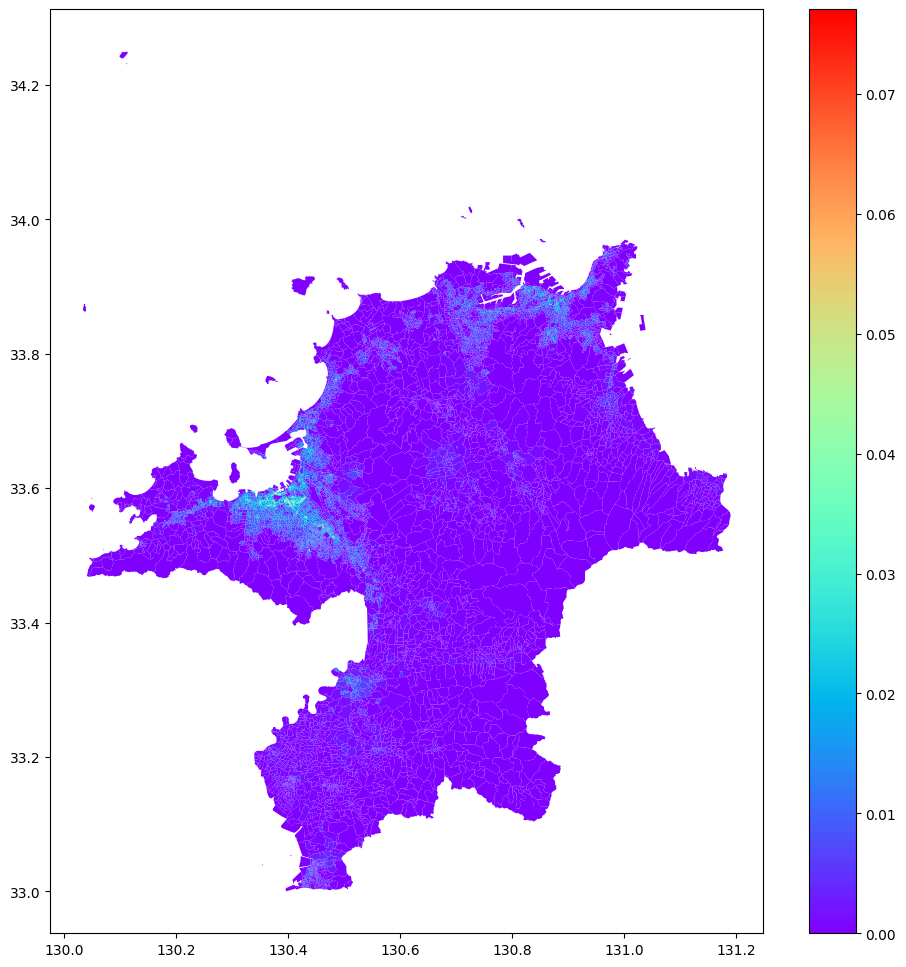

In [13]:
# 人口密度 (POP_DENSITY) を反映した可視化
fig, ax = plt.subplots(1, figsize=(12, 12))
fukuoka.plot(ax=ax, column='POP_DENSITY', cmap='rainbow', legend=True) # cmap='hot'

上記の結果から，北九州市，福岡市，鳥栖市，久留米市，鳥栖市，大牟田市の人口密度が高いことが明らかである。

#### 人口密度が高い地域はどこ？
人口密度を降順に並べると次のようになる。

In [14]:
fukuoka['POP_DENSITY'].sort_values(ascending=False)

3385    0.077058
2128    0.051145
5534    0.045408
2074    0.043871
2078    0.043546
          ...   
4510    0.000000
4511    0.000000
4513    0.000000
4514    0.000000
0       0.000000
Name: POP_DENSITY, Length: 7822, dtype: float64

第１位は 0.077，第2位は 0.051 という人口密度である。
これらはどこか，を調べると，次の結果となった。
- 第1位： 飯塚市 伊岐須
- 第2位：福岡市中央区 荒戸二丁目

In [20]:
fukuoka[fukuoka['POP_DENSITY'] > 0.05]

,KEY_CODE,PREF,CITY,S_AREA,PREF_NAME,CITY_NAME,S_NAME,KIGO_E,HCODE,AREA,...,N_CITY,KIGO_I,KBSUM,JINKO,SETAI,X_CODE,Y_CODE,KCODE1,geometry,POP_DENSITY
2128,40133037002,40,133,037002,福岡県,福岡市中央区,荒戸二丁目,None,8101,78932.722,...,None,None,46,4037,2383,130.376486,33.592277,0370-02,"POLYGON ((130.37704 33.59443, 130.37721 33.594...",0.051145
3385,40205024001,40,205,024001,福岡県,飯塚市,伊岐須,None,8101,415.272,...,None,None,1,32,1,130.656970,33.655288,0240-01,"POLYGON ((130.65687 33.65529, 130.65687 33.655...",0.077058


#### 福岡市や北九州市のみ抽出して，人口密度を可視化する。
福岡市や北九州市の CITY_NAME は "福岡市中央区" や ”北九州市小倉北区" という表記となっている。そこで， `str.startswith()` を利用して，特定の地域のデータを抽出する。

<Axes: >

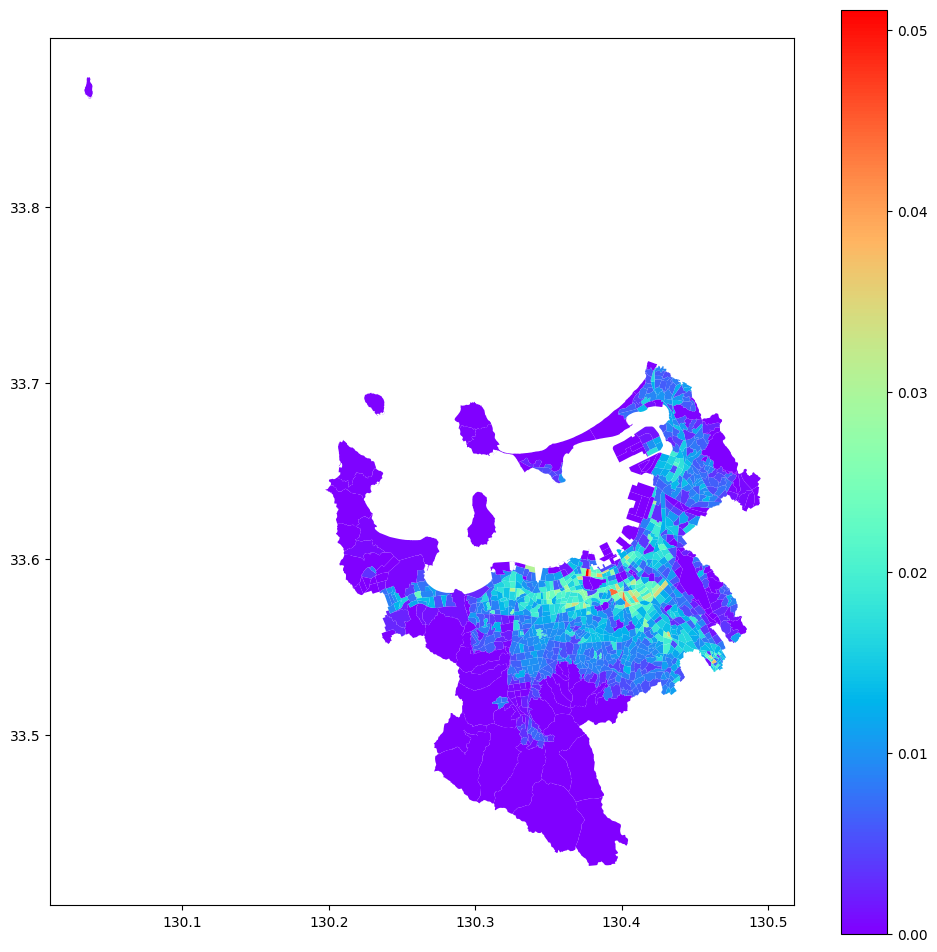

In [21]:
# 福岡市のみを抽出
fukuoka_city = fukuoka.copy()
fukuoka_city = fukuoka_city[fukuoka['CITY_NAME'].str.startswith('福岡市')]

# 可視化
fig, ax = plt.subplots(1, figsize=(12, 12))
fukuoka_city.plot(ax=ax, column='POP_DENSITY', cmap='rainbow', legend=True) # cmap='hot'

<Axes: >

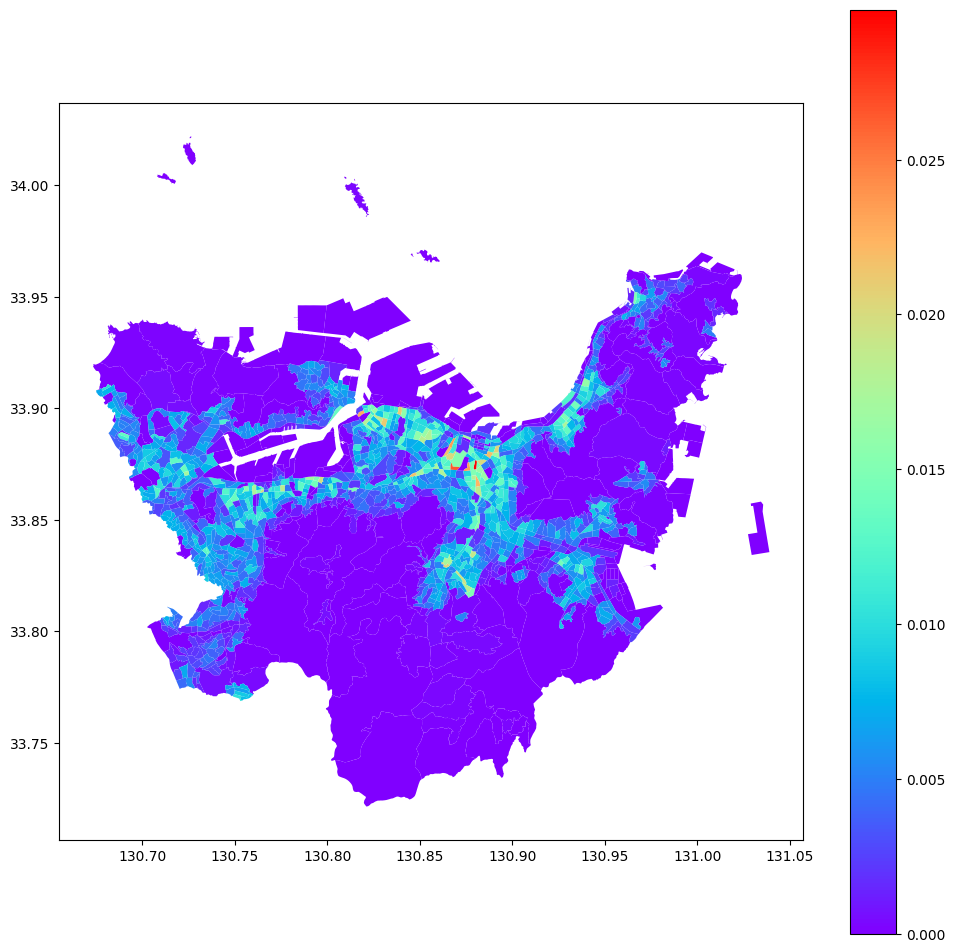

In [22]:
# 北九州市のみを抽出
kitakyu_city = fukuoka.copy()
kitakyu_city = kitakyu_city[fukuoka['CITY_NAME'].str.startswith('北九州市')]

fig, ax = plt.subplots(1, figsize=(12, 12))
kitakyu_city.plot(ax=ax, column='POP_DENSITY', cmap='rainbow', legend=True) # cmap='hot'

---
### Folium を使ってみる
geopandas + shape file を用いると人口密度を可視化できるものの，地名等が表示されないため，解釈が困難となる。
そこで **Folium** というライブラリを使ってみよう。

Folium とは，leaflet.js というJavascriptの地図ライブラリをPythonで使えるよう，ライブラリ化したものである。

以下に Folium を用いて地図を描画するコードを示す。
手順は次ののとおりである：
1. 図の生成 (`folium.Figure`)
1. 地図を表示する際の中心位置，拡大率の指定
1. 地図の生成 & 図への追加 (`folium.Map` & `add_to`メソッド)
1. 地図の表示

In [23]:
import folium
from folium.plugins import HeatMap

# 図の大きさを指定する。
f = folium.Figure(width=1000, height=500)

# 初期表示の中心の座標を指定して地図を作成する。
# (メモ) 小倉駅を中心とした
center_lat=33.886968
center_lon=130.882576
zoom = 8
map = folium.Map([center_lat,center_lon], zoom_start=zoom).add_to(f)

map # 表示

#### Folium 上で人口密度分布を可視化する方法
Folum にて各地域ごとの人口密度を反映するには次の２つの方法がある。
- shape データを geojson 形式へ変換し，メッシュ状で表現する
- **Folium のプラグインである HeatMap を用いてヒートマップを作成し，地図に重ねる。**

以下では後者の HeatMap を用いる。

手順は次のとおりである。
1. 各ポリゴンの中心座標を求め，人口密度を値（高さ）としてヒートマップデータを作る。
1. Folium を用いて地図を作る。
1. ヒートマップデータを地図に加える。

(予備知識) geodataframe 内の geometry から「ポリゴンの中心座標」を得る方法を確認しておく。

In [32]:
# for ループで回したいから，index 番号をリセット
kitakyu_city = kitakyu_city.reset_index()

# 先頭要素の座標（緯度，経度）の取得
point = kitakyu_city['geometry'][0].centroid # polygon の中心座標を得る
print(point) # 経度，緯度の順番で位置情報が格納されている
longitude, latitude = point.x, point.y # 経度=longitude, 緯度=latitude
print(longitude, latitude)

POINT (130.9208270055909 33.88499302063822)
130.9208270055909 33.88499302063822


以下に人口密度分布をヒートマップとして表現するコードを示す。

In [35]:
import folium
from folium.plugins import HeatMap

# for ループで回したいから，index 番号をリセット
# kitakyu_city = kitakyu_city.reset_index()

# ヒートマップ用のデータを構築する
heatmap_data = []
for i in range(len(kitakyu_city)):
    point = kitakyu_city['geometry'][i].centroid # 各 geometry の中心座標を取得する
    longitude, latitude = point.x, point.y # 経度(longtitude)，緯度(latitude) を取り出す

    # ヒートマップに渡すデータは第１引数が latitude(緯度)，第２引数が longitude(経度)，第３引数が値の高さ
    # 特に latitude, longitude の順番に注意！
    heatmap_data.append([latitude, longitude, kitakyu_city['POP_DENSITY'][i]])

# 図の大きさを指定する。
f = folium.Figure(width=1000, height=500)

# 初期表示の中心の座標を指定して地図を作成する。
# (メモ) 小倉駅を中心とした
center_lat=33.886968
center_lon=130.882576
zoom = 12 #4
map = folium.Map([center_lat,center_lon], zoom_start=zoom).add_to(f)

# ヒートマップデータを地図に重ねる
HeatMap(heatmap_data, radius=30, blur=40).add_to(map)

map # 表示

---
# (おまけ) オープンデータ + Folium
位置情報データは常に shape ファイルとして与えられるとは限らない。

以下ではスターバックスの店舗データを例として，オープンデータから店舗位置を取得し，Folium の地図に重ねる話題を提供する。

## データセット：Starbucks Locations Worldwide
世界中の Starbucks の店舗情報(25,600店！)を収集したファイルが Kaggle にて公開されている。

Starbucks Locations Worldwide  
https://www.kaggle.com/starbucks/store-locations

ただし，「2017年2月現在，営業中の店舗が対象」というデータゆえ，宇部店は含まれない。
また，位置情報（緯度・経度の情報）の精度が粗い点も気になる。

In [36]:
import pandas as pd

# データの読み込み
path = r'/content/drive/My Drive/BASE/GeoData/Starbucks/directory.csv'
starbucks = pd.read_csv(path)

In [37]:
# データの先頭を覗き見る
starbucks.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
0,Starbucks,47370-257954,"Meritxell, 96",Licensed,"Av. Meritxell, 96",Andorra la Vella,7,AD,AD500,376818720,GMT+1:00 Europe/Andorra,1.53,42.51
1,Starbucks,22331-212325,Ajman Drive Thru,Licensed,"1 Street 69, Al Jarf",Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.42
2,Starbucks,47089-256771,Dana Mall,Licensed,Sheikh Khalifa Bin Zayed St.,Ajman,AJ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,55.47,25.39
3,Starbucks,22126-218024,Twofour 54,Licensed,Al Salam Street,Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.38,24.48
4,Starbucks,17127-178586,Al Ain Tower,Licensed,"Khaldiya Area, Abu Dhabi Island",Abu Dhabi,AZ,AE,NaN,NaN,GMT+04:00 Asia/Dubai,54.54,24.51


In [38]:
# 日本国内の店舗情報のみを抽出
starbucks_jp = starbucks.copy() # 元データを壊さないよう，コピー
starbucks_jp = starbucks_jp[starbucks['Country'].isin(['JP'])]

In [39]:
# データの先頭を覗き見る
starbucks_jp.head()

,Brand,Store Number,Store Name,Ownership Type,Street Address,City,State/Province,Country,Postcode,Phone Number,Timezone,Longitude,Latitude
6739,Starbucks,26291-235224,AEON MALL Asahikawa Eki-mae,Joint Venture,7-2-5 Miyashita-dori,Asahikawa,1,JP,070-0030,NaN,GMT+09:00 Asia/Tokyo,142.36,43.76
6740,Starbucks,31568-111246,Asahikawa Medical College Hospital,Joint Venture,1-1 Midorigaoka-higashi 2jo 1,Asahikawa,1,JP,078-8510,NaN,GMT+09:00 Asia/Tokyo,142.38,43.73
6741,Starbucks,47076-251782,Asahikawa Toko,Company Owned,6-207-5 13jo Higashimitsu,Asahikawa,1,JP,078-8353,NaN,GMT+09:00 Asia/Tokyo,142.41,43.74
6742,Starbucks,30540-94875,AEON MALL Asahikawa-nishi,Joint Venture,2161-3 23-chome Midorimachi,Asahikawa,1,JP,070-0823,NaN,GMT+09:00 Asia/Tokyo,142.32,43.79
6743,Starbucks,15352-156247,New Chitose Airport,Joint Venture,Bibi Chitose,Chitose,1,JP,066-0012,NaN,GMT+09:00 Asia/Tokyo,141.68,42.79


### スターバックス店舗の位置情報の抽出 ＆ Folium のマーカー利用

In [40]:
# 位置情報のみを取り出し，リスト points へ格納
points = []
for idx, data in starbucks_jp.iterrows():
    points.append([data['Longitude'], data['Latitude']])

points[:5] # 先頭５件を確認

[[142.36, 43.76],
 [142.38, 43.73],
 [142.41, 43.74],
 [142.32, 43.79],
 [141.68, 42.79]]

スターバックの店舗がある位置にマーカー (marker) を設定し，Folium の地図に重ねる。

In [41]:
import folium

# 図の大きさを指定する。
f = folium.Figure(width=1000, height=500)

# 初期表示の中心の座標を指定して地図を作成する。
# (メモ) 東京駅の所在地を中心とした
center_lat=35.681236
center_lon=139.767125
zoom = 4
m = folium.Map([center_lat,center_lon], zoom_start=zoom).add_to(f)

# 地図にマーカーを追加
for point in points:
    latitude, longitude = point
    folium.Marker(location=[longitude, latitude]).add_to(m) # 座標(location)は経度(longitude)，緯度(latitude)の順

m # 表示

---
## (おまけ) 東京都の人口分布
もっとも人口の多い東京都の人口分布を可視化する。

予め「東京都全域」の shape data を入手しておくことが前提である。

<Axes: >

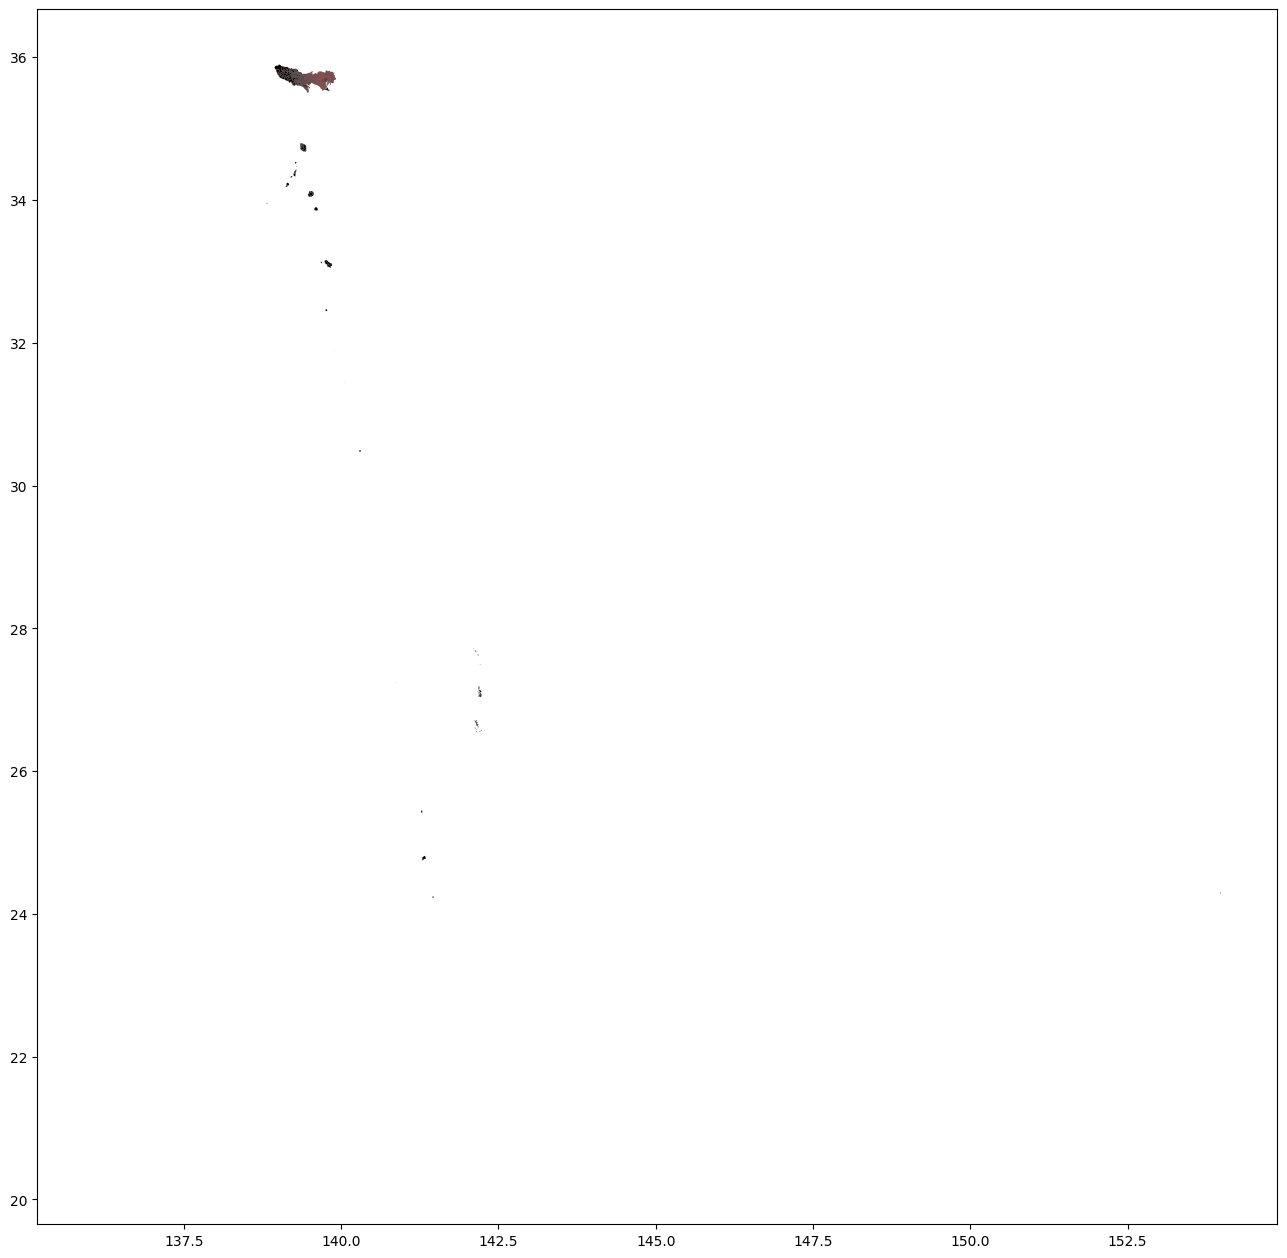

In [42]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 地理情報データの読み込み
tokyo = gpd.read_file(r'/content/drive/My Drive/BASE/GeoData/e-stat/Tokyo/h27ka13.shp')
tokyo = tokyo[tokyo['HCODE'] != 8154] # 海を除く

# 人口密度を求める
tokyo['POP_DENSITY'] = tokyo['JINKO'] / tokyo['AREA']

# 可視化
fig, ax = plt.subplots(1, figsize=(16, 16))
tokyo.plot(ax=ax, column='POP_DENSITY', cmap='hot')

### 東京都が小さくなってしまった！！
実は，伊豆諸島と小笠原諸島は東京都の一部であり，東京都はかなり広範囲に存在するのが原因である。

上記の出力から判断するに，伊豆諸島と小笠原諸島を除くには「北緯 >= 35度以上」に限定すればよさそうである。

読み込んだ GeoDataframe において「X_CODE」が経度，「Y_CODE」が緯度に当たることから，これを利用する。

<Axes: >

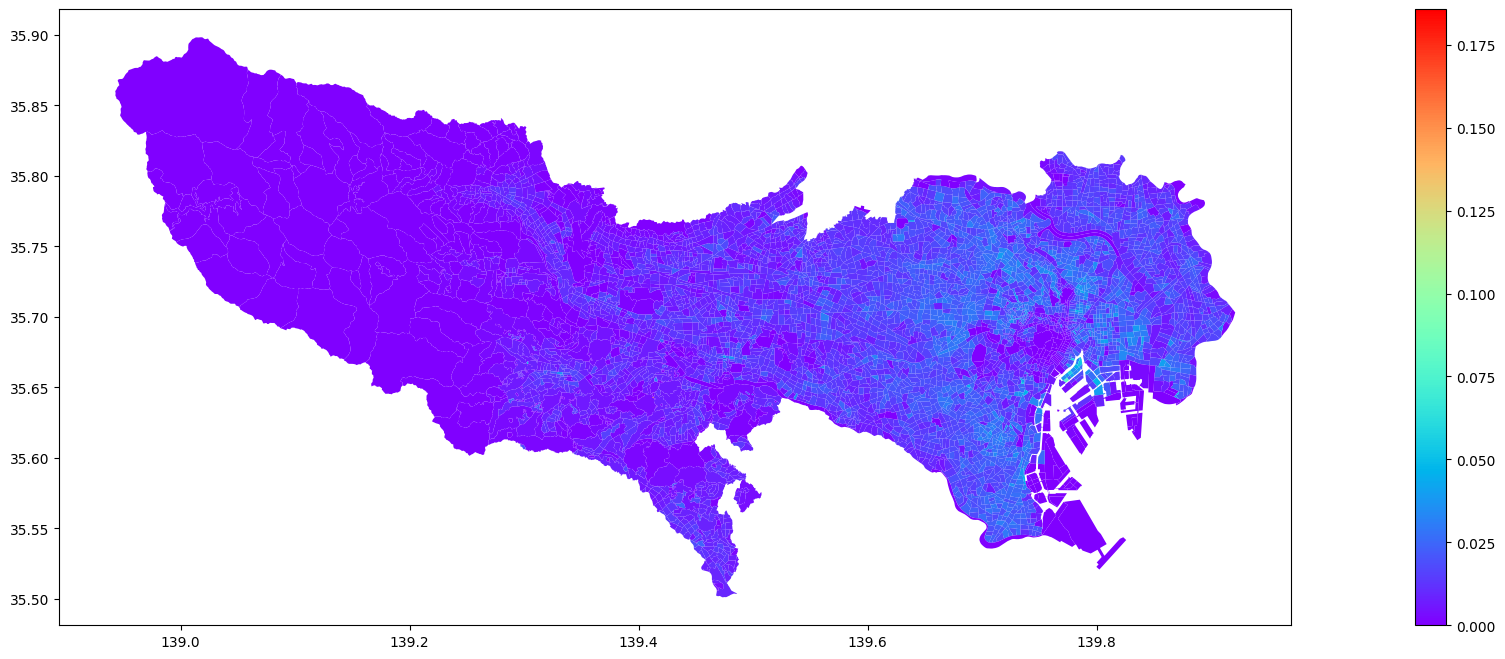

In [43]:
import geopandas as gpd
import matplotlib.pyplot as plt

# 地理情報データの読み込み
tokyo = gpd.read_file(r'/content/drive/My Drive/BASE/GeoData/e-stat/Tokyo/h27ka13.shp')
tokyo = tokyo[tokyo['HCODE'] != 8154] # 海を除く
tokyo = tokyo[tokyo['Y_CODE'] >= 35.0] # 島しょ部を除く <<<==== It's NEW !

# 人口密度を求める
tokyo['POP_DENSITY'] = tokyo['JINKO'] / tokyo['AREA']

# 可視化
fig, ax = plt.subplots(1, figsize=(32, 8))
tokyo.plot(ax=ax, column='POP_DENSITY', cmap='rainbow', legend=True)